In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [18]:
x_item_train = pd.read_csv('../../../data/input_formated/final/x_item_train.csv').iloc[:, 1:]
y_train = pd.read_csv('../../../data/input_formated/final/y_train.csv').iloc[:, 1:]

In [15]:
x_item_val = pd.read_csv('../../../data/input_formated/final/x_item_val.csv').iloc[:, 1:]
y_val_df = pd.read_csv('../../../data/input_formated/final/y_val.csv').iloc[:, 1:]
y_val = y_val_df

In [16]:
item_features = [u'category_Action', u'category_Adventure',
       u'category_Animation', u'category_Children\'s', u'category_Comedy',
       u'category_Crime', u'category_Documentary', u'category_Drama',
       u'category_Fantasy', u'category_Film-Noir', u'category_Horror',
       u'category_Musical', u'category_Mystery', u'category_Romance',
       u'category_Sci-Fi', u'category_Thriller', u'category_War',
       u'category_Western']

target_features = ['rating']

In [19]:
x_train = np.array(x_item_train[item_features], dtype = np.float32)
y_train = np.array(y_train[target_features], dtype=np.float32).reshape((-1, 1))

In [20]:
x_val = np.array(x_item_val[item_features], dtype = np.float32)
y_val = np.array(y_val[target_features], dtype=np.float32).reshape((-1, 1))

# ANN

In [8]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [21]:
def val_error(model):
    inputs = Variable(torch.from_numpy(np.array(x_val, dtype = np.float32)))
    outputs = model(inputs).data[:,0]
    tmp = y_val_df
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index() * 5, dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index() * 5, dtype = np.float32)[: ,1].reshape((-1,1))
    return np.sqrt(np.mean((target - output) * (target - output)))

In [9]:
class ANN_1input(nn.Module):
    def __init__(self, input_0_size, hidden_size, output_size):
        super(ANN_1input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, hidden_size) 
        self.activate0 = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x):
        h = self.activate0(self.fc0(x))
        return self.activate(self.bn(self.fc(h)))

In [ ]:
def val_error(model):
    inputs_0 = Variable(torch.from_numpy(np.array(x_0_val, dtype = np.float32)))
    inputs_1 = Variable(torch.from_numpy(np.array(x_1_val, dtype = np.float32)))
    outputs = model(inputs_0, inputs_1).data[:,0]
    tmp = y_val_df
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index() * 5, dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index() * 5, dtype = np.float32)[: ,1].reshape((-1,1))
    return np.sqrt(np.mean((target - output) * (target - output)))

In [26]:
def train(x_train, y_train, x_val, y_val, learning_rate, num_epochs, check_point, old_epochs=0, model_save= None, model = None, max_patience = 200):
	if model is None:
		model = ANN_1input(x_train.shape[1], 10, y_train.shape[1])
    
	# Loss and Optimizer
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
	train_loss_list, val_loss_list = [], []

	#early stopping
	patience = max_patience
	best_val = None
	num_epochs += old_epochs
	# Train the Model 
	for epoch in range(old_epochs, num_epochs):
		# Convert numpy array to torch Variable
		inputs = Variable(torch.from_numpy(x_train))
		targets = Variable(torch.from_numpy(y_train), requires_grad = False)

		# Forward + Backward + Optimize
		optimizer.zero_grad()  
		outputs = model(inputs)
		
		train_loss = criterion(outputs, targets)
		train_loss_list.append(train_loss.data[0])
		
		#validate
		inputs = Variable(torch.from_numpy(x_val))
		targets = Variable(torch.from_numpy(y_val), requires_grad = False)
		outputs = model(inputs)   
		val_loss = criterion(outputs, targets)
		val_loss_list.append(val_loss.data[0])
		val_err = val_error(model)
		#optimize
		train_loss.backward()
		optimizer.step()
		
		if (epoch == 0) or ((epoch+1) % check_point == 0) or (epoch == num_epochs-1):
			print ('Epoch [%d/%d], Training Loss: %.4f, Validating Loss: %.4f, Val Error: %.4f' 
				   %(epoch+1, num_epochs, train_loss.data[0], val_loss.data[0], val_err))
			if model_save is not None:
				torch.save(model, '%s_%d.pth' % (model_save, epoch+1))

		if (best_val is None) or ((best_val is not None) and (val_err < best_val)) :
			best_val = val_err
			patience = max_patience
		else:
			patience -= 1
		if patience == 0:
			print 'Early stopping at %d' % epoch
			break
		

	# Plot the graph
	print 'Plot graph from epoch 10th'
	plt.plot(range(len(train_loss_list))[10:], train_loss_list[10:], label='train')
	plt.plot(range(len(train_loss_list))[10:], val_loss_list[10:], label = 'validate')
	plt.legend()
	plt.show()
	return model

Epoch [1/1000], Training Loss: 0.0973, Validating Loss: 0.0944


/home/anla/Apps/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ANN_1input. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [10/1000], Training Loss: 0.0875, Validating Loss: 0.0847
Epoch [20/1000], Training Loss: 0.0780, Validating Loss: 0.0753
Epoch [30/1000], Training Loss: 0.0705, Validating Loss: 0.0680
Epoch [40/1000], Training Loss: 0.0645, Validating Loss: 0.0626
Epoch [50/1000], Training Loss: 0.0601, Validating Loss: 0.0584
Epoch [60/1000], Training Loss: 0.0567, Validating Loss: 0.0552
Epoch [70/1000], Training Loss: 0.0542, Validating Loss: 0.0529
Epoch [80/1000], Training Loss: 0.0525, Validating Loss: 0.0513
Epoch [90/1000], Training Loss: 0.0512, Validating Loss: 0.0501
Epoch [100/1000], Training Loss: 0.0503, Validating Loss: 0.0493
Epoch [110/1000], Training Loss: 0.0496, Validating Loss: 0.0488
Epoch [120/1000], Training Loss: 0.0493, Validating Loss: 0.0485
Epoch [130/1000], Training Loss: 0.0489, Validating Loss: 0.0482
Epoch [140/1000], Training Loss: 0.0486, Validating Loss: 0.0481
Epoch [150/1000], Training Loss: 0.0485, Validating Loss: 0.0480
Epoch [160/1000], Training Loss: 0

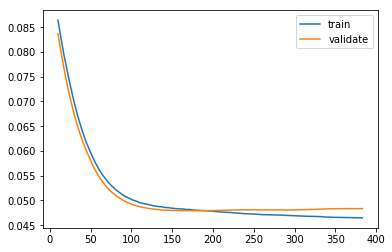

In [13]:
model_ex1 = train(x_train, y_train, x_val, y_val, learning_rate = 0.01, num_epochs= 1000, check_point = 10, max_patience = 200, model_save = 'final_without-user/ex-1')

Epoch [1/1000], Training Loss: 0.0971, Validating Loss: 0.0941, Val Error: 0.9967
Epoch [10/1000], Training Loss: 0.0960, Validating Loss: 0.0931, Val Error: 0.9871
Epoch [20/1000], Training Loss: 0.0949, Validating Loss: 0.0920, Val Error: 0.9762
Epoch [30/1000], Training Loss: 0.0938, Validating Loss: 0.0908, Val Error: 0.9654
Epoch [40/1000], Training Loss: 0.0927, Validating Loss: 0.0897, Val Error: 0.9545
Epoch [50/1000], Training Loss: 0.0916, Validating Loss: 0.0886, Val Error: 0.9435
Epoch [60/1000], Training Loss: 0.0904, Validating Loss: 0.0875, Val Error: 0.9324
Epoch [70/1000], Training Loss: 0.0894, Validating Loss: 0.0864, Val Error: 0.9213
Epoch [80/1000], Training Loss: 0.0883, Validating Loss: 0.0854, Val Error: 0.9103
Epoch [90/1000], Training Loss: 0.0874, Validating Loss: 0.0844, Val Error: 0.8995
Epoch [100/1000], Training Loss: 0.0864, Validating Loss: 0.0834, Val Error: 0.8891
Epoch [110/1000], Training Loss: 0.0854, Validating Loss: 0.0824, Val Error: 0.8791
Epo

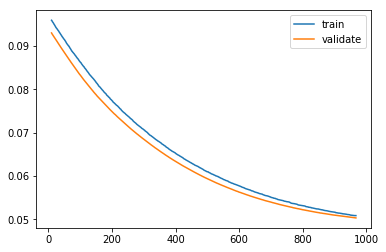

In [23]:
model_ex2 = train(x_train, y_train, x_val, y_val, learning_rate = 0.001, num_epochs= 1000, check_point = 10, max_patience = 200, model_save = 'final_without-user/ex-2')

Epoch [1/2000], Training Loss: 0.0971, Validating Loss: 0.0943, Val Error: 1.0002
Epoch [10/2000], Training Loss: 0.0960, Validating Loss: 0.0932, Val Error: 0.9900
Epoch [20/2000], Training Loss: 0.0948, Validating Loss: 0.0920, Val Error: 0.9787
Epoch [30/2000], Training Loss: 0.0937, Validating Loss: 0.0909, Val Error: 0.9674
Epoch [40/2000], Training Loss: 0.0925, Validating Loss: 0.0897, Val Error: 0.9561
Epoch [50/2000], Training Loss: 0.0914, Validating Loss: 0.0886, Val Error: 0.9449
Epoch [60/2000], Training Loss: 0.0903, Validating Loss: 0.0875, Val Error: 0.9337
Epoch [70/2000], Training Loss: 0.0893, Validating Loss: 0.0864, Val Error: 0.9225
Epoch [80/2000], Training Loss: 0.0881, Validating Loss: 0.0853, Val Error: 0.9115
Epoch [90/2000], Training Loss: 0.0871, Validating Loss: 0.0843, Val Error: 0.9006
Epoch [100/2000], Training Loss: 0.0861, Validating Loss: 0.0833, Val Error: 0.8902
Epoch [110/2000], Training Loss: 0.0851, Validating Loss: 0.0823, Val Error: 0.8802
Epo

Epoch [980/2000], Training Loss: 0.0506, Validating Loss: 0.0502, Val Error: 0.6583
Epoch [990/2000], Training Loss: 0.0505, Validating Loss: 0.0501, Val Error: 0.6591
Epoch [1000/2000], Training Loss: 0.0504, Validating Loss: 0.0501, Val Error: 0.6599
Epoch [1010/2000], Training Loss: 0.0502, Validating Loss: 0.0500, Val Error: 0.6607
Epoch [1020/2000], Training Loss: 0.0501, Validating Loss: 0.0499, Val Error: 0.6616
Epoch [1030/2000], Training Loss: 0.0501, Validating Loss: 0.0499, Val Error: 0.6624
Epoch [1040/2000], Training Loss: 0.0499, Validating Loss: 0.0498, Val Error: 0.6633
Epoch [1050/2000], Training Loss: 0.0499, Validating Loss: 0.0497, Val Error: 0.6642
Epoch [1060/2000], Training Loss: 0.0498, Validating Loss: 0.0497, Val Error: 0.6651
Epoch [1070/2000], Training Loss: 0.0498, Validating Loss: 0.0496, Val Error: 0.6661
Epoch [1080/2000], Training Loss: 0.0497, Validating Loss: 0.0496, Val Error: 0.6670
Epoch [1090/2000], Training Loss: 0.0495, Validating Loss: 0.0495, 

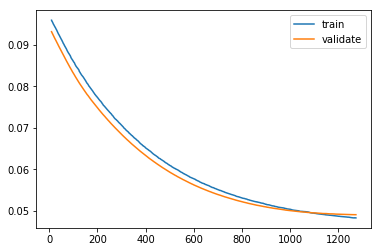

In [28]:
model_ex2_3 = train(x_train, y_train, x_val, y_val, learning_rate = 0.001, num_epochs= 2000, old_epochs = 0, check_point = 10, max_patience = 500, model_save = 'final_without-user/ex-3')